# Importing Libraries

In [84]:
import torch
import pdb
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [85]:
def show_tensor_img(tensor, channel = 1, size = (28, 28), num_of_images = 16):
    """
    with this function we are saying take first 32 images and plugging nrow = 4 makes grid 4x4
    our input tensor will be 128x784 -> 128 batch size, 784 = 28*28.
    In functions dt part we are resisizing our tensor *size -> makes 784 to 28x28 again.
    channel is 1 so it makes 1x28x28
    -1 means whatever remains after we take so it will be 128x1x28x28
    we are using .detach() because it is detaching variable from computation of gradients. No need gradient
    using .cpu() so we are making training process on gpu so visualize on cpu

    with .permute() we are changing order of dims. It gave us 32x1x28x28 but grid is giving us series of
    images that have 1x28x28 internal structure but if we want to use matplotlib order needs to be w,h,c
    28x28x1
    """
    dt = tensor.detach().cpu().view(-1,channel, *size)
    grid = make_grid(dt[:num_of_images], nrow = 4).permute(1,2,0)
    plt.imshow(grid)
    plt.show()

# Parameters

In [86]:
epochs = 300
#we process one batch, one set of images. Trach current step
current_step = 0
# In how many steps we want to show in screen, information about current loss values, images generated , etc
info_step = 100

#before showing info we accumulate that information
mean_generator_loss = 0
mean_discriminator_loss = 0

#dimensionality of that latent space that we're going to learn of that noise vector that is the input of the generator
z_dim = 64
lr = 0.0001

#Loss Function
loss_function = nn.BCEWithLogitsLoss()

BATCH_SIZE = 32

device = "cuda" if torch.cuda.is_available else "cpu"

dataloader = DataLoader(MNIST(".", download = True, transform = transforms.ToTensor()),
                        shuffle = True, #shuffle every epoch
                        batch_size = BATCH_SIZE)
#number of steps = 60000/128 = 468.75 step in every epoch. Last step will be less.


# Models

## Generator

In [87]:
def generatorBlock(input_size, output_size):
    return nn.Sequential(
        nn.Linear(input_size, output_size),
        nn.BatchNorm1d(output_size), #normalize the values that are coming previous layer.Makes more
        #stable the training when we usei multiple layers.
        nn.ReLU(inplace = True) #with inplace it'll modify the input directly without allocationing
        #extra resourches. Decrease memory usage
    )

class Generator(nn.Module):
    def __init__(self, z_dim = 64, image_dim = 784, hidden_dim = 128):
        """
        z_dim -> noise dimension
        image_dim -> 28x28
        base size first hidden layer size hidden_dim
        """
        super().__init__() #initialize parent class
        self.generator = nn.Sequential(
            #increase the size generate an image of the size of images of the MNIST dataset
            generatorBlock(z_dim, hidden_dim), #64 ->128
            generatorBlock(hidden_dim, hidden_dim*2), #128 ->256
            generatorBlock(hidden_dim*2, hidden_dim*4), #256 ->512
            generatorBlock(hidden_dim*4, hidden_dim*8), #512 ->1024
            #for the output we're gonna set a single linear layer fc layer that is gonna go
            #from previous output h_dim*8 tı size of whatever we want to generate in output
            nn.Linear(hidden_dim*8, image_dim), #1024 ->784(28x28) MNIST Size
            nn.Sigmoid(), #setting the values between 0-1
        )

        #we need forward function is gonna be executed when running the instance of the class
    def forward(self, noise): #input noise vector
        return self.generator(noise)


## Noise Generator

In [88]:
def noise_generator(num_of_vectors, z_dim):
    """
    torch.randn stochastic function that is gonna return a tensor field with random numbers
    from a normal distribution with mean of zero and variance one. Called standard normal distribution
    """
    return torch.randn(num_of_vectors, z_dim).to(device) #input in gpu


## Discriminator

In [89]:
def discriminatorBlock(input_size , output_size):
    return nn.Sequential(
        nn.Linear(input_size, output_size),
        nn.LeakyReLU(0.2) #for solving dead relu problem
    )

class Discriminator(nn.Module):
    def __init__(self, image_dim = 784, hidden_dim = 128):
        super().__init__()
        self.discriminator = nn.Sequential(
            discriminatorBlock(image_dim, hidden_dim*4), #784->1024
            discriminatorBlock(hidden_dim*4, hidden_dim*2), #1024->512
            discriminatorBlock(hidden_dim*2, hidden_dim), #512->256
            nn.Linear(hidden_dim, 1)#256->1
        )
    def forward(self,image):
        return self.discriminator(image)

# Device Management and Optimizer

In [90]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = torch.optim.Adam(generator.parameters(),
                                       lr = lr)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),
                                           lr = lr)

In [91]:
generator

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [92]:
discriminator

Discriminator(
  (discriminator): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Creating X and y from MNIST Dataset Dataloader

In [93]:
X, y = next(iter(dataloader))
# X datas y labels
print(X.shape, y.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [94]:
print(y[:10])

tensor([7, 4, 9, 9, 8, 8, 0, 9, 9, 9])


# Generate Noise and Generate first noise

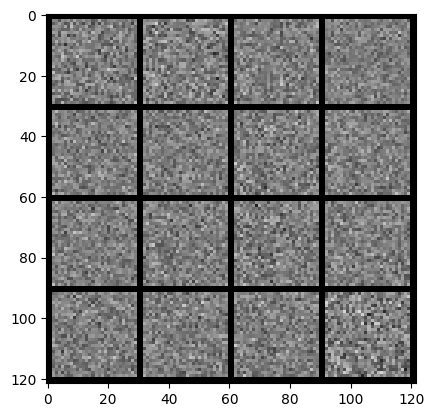

In [95]:
noise = noise_generator(BATCH_SIZE, z_dim)
fake = generator(noise)
show_tensor_img(fake)

These are pure random noise. We're gonna try to train the network to transform real images.

# Calculating Loss

## Generator Loss

In [96]:
def generator_loss_calc(loss_function, generator, discriminator, num_elements, z_dim):
  noise = noise_generator(num_elements, z_dim)
  fake = generator(noise)
  prediction = discriminator(fake)

  target = torch.ones_like(prediction)
  generator_loss = loss_function(prediction, target)
  return generator_loss


## Discriminator Loss

In [97]:
def discriminator_loss_calc(loss_function, generator, discriminator, num_elements, real, z_dim):
  noise = noise_generator(num_elements, z_dim)
  fake = generator(noise)
  """
  When pytorch backpropagades this loss basically calculating the gradients we dont want to change
  parameters of generator when we are optimizing discriminator we only want to optimize parameters of
  discriminator so detach fake images from calculation of the gradients.
  """
  discriminator_fake = discriminator(fake.detach())

  discriminator_fake_target = torch.zeros_like(discriminator_fake)
  discriminator_fake_loss = loss_function(discriminator_fake, discriminator_fake_target)

  discriminator_real = discriminator(real)
  discriminator_real_target = torch.ones_like(discriminator_real)
  discriminator_real_loss = loss_function(discriminator_real, discriminator_real_target)

  discriminator_loss = (discriminator_fake_loss + discriminator_real_loss)/2
  return discriminator_loss



# Training
As we mentioned before there are 60000 data 60000/128 = 468.75 steps in each epoch.

In [98]:

generator_loss_mean = 0
discriminator_loss_mean = 0


In [99]:
for epoch in range(epochs):
    for real, _ in tqdm(dataloader):
        """
        we would receive a set of labels but we don't need labels for anything because it is not supervised learning
        """

        # Discriminator
        discriminator_optimizer.zero_grad()

        current_batch_size = len(real)
        """
        length size of those real images that are returned each step
        real: 128x1x28x28 but in last step may less that 128
        """
        real = real.view(current_batch_size, -1).to(device)

        discriminator_loss = discriminator_loss_calc(loss_function, generator, discriminator, current_batch_size, real, z_dim)
        discriminator_loss.backward(retain_graph=True)
        """
        if we don't use retain_graph graph used to compute gradients is going to be freed. If not it is gonna be kept in memory
        to be accessed by different variables all around optional
        """
        discriminator_optimizer.step()  # update parameters

        # Generator
        generator_optimizer.zero_grad()
        generator_loss = generator_loss_calc(loss_function, generator, discriminator, current_batch_size, z_dim)
        generator_loss.backward(retain_graph=True)
        generator_optimizer.step()

        # Visualizing statistics
        discriminator_loss_mean += discriminator_loss.item() / info_step
        generator_loss_mean += generator_loss.item() / info_step
        """
        in this part we are adding the values in proportion to the period in which we are going to visualize
        information so that at the end, when we visualize information every 100 step in this case we're going to see
        the average of losses
        """

        if current_step % info_step == 0 and current_step > 0:
            fake_noise = noise_generator(current_batch_size, z_dim)
            fake = generator(fake_noise)
            show_tensor_img(fake)
            show_tensor_img(real)
            print(f"Step {current_step}: Generator loss: {generator_loss_mean}, Discriminator loss: {discriminator_loss_mean}")
            generator_loss_mean = 0  # for new steps
            discriminator_loss_mean = 0

        current_step += 1


Output hidden; open in https://colab.research.google.com to view.